## Importing everything

In [1]:
import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pyNetLogo
import time
import string
from scipy.optimize import brentq
from datetime import datetime

from __future__ import (division, unicode_literals, absolute_import,
                        print_function)
from matplotlib.pyplot import figure

from ema_workbench import (TimeSeriesOutcome, ArrayOutcome, perform_experiments,
                           RealParameter, ema_logging, Constant, Policy, Scenario)
from ema_workbench.connectors import vensim, netlogo
from ema_workbench.connectors.vensim import VensimModel, set_value
from ema_workbench.connectors.netlogo import NetLogoModel
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
outcomes = [TimeSeriesOutcome('Exposed[0,not isolated,"High-risk","non-vaccinated"]'),
            #TimeSeriesOutcome('Sick'),
            #TimeSeriesOutcome('Immune'),
            TimeSeriesOutcome('TIME')
           ]
uncertainties = [RealParameter("Uncertain",0,1)]
condition = (max, "Sick", 100)
Relevant_vars = ["Healthy", "Sick", "Immune","TIME"]

## Functions

In [3]:
def run_everything(V_model,run_length=1000):
    nl_model.load_model('Simpel Virus ABM.nlogo')
    nl_df = run_netlogo(nl_model,Relevant_vars,condition,length=run_length)
    All_df = run_vensim_exp(nl_df, V_model)
    while (run_length-2) > max(All_df.index):
        All_df = pre_run_netlogo(All_df,run_length)
        All_df = run_vensim_exp(All_df, V_model)
    All_df = All_df[:run_length]
    return All_df

def coarse_rep (V_model,replications = 100, run_length=2000):
    df = run_everything (V_model, run_length)
    var_list = []
    for i in df:
        var_list.append(i)
    for i in range(replications-1):
        df1 = run_everything(V_model,run_length)
        df = df.join(df1,how="outer",rsuffix="1")
        df.dropna(inplace = True)
        for j in var_list:
            df[j] = df[j]+df[j+"1"]
            df.drop(j+"1",axis = "columns",inplace=True)
        print("%d runs of %d completed"%(i+2,replications))
    df.drop("TIME",axis="columns",inplace=True)
    return (df/replications)

In [4]:
def pre_run_netlogo (df,length):
    nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"]))
    nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))
    nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"]))
    nl_df = run_netlogo(nl_model,Relevant_vars,condition, extra_setup=["ask turtles with [sick?] [set sick-time random duration]","set TIME %d"% max(df.index)],length=length)
    nl_df.index = nl_df.index + max(df.index)
    return pd.concat([df,nl_df])

In [5]:
def run_vensim_exp(df,V_model,breaker = True):
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    if len(df)>0:
        V_constants = [Constant('Initial Healthy', df.at[max(df.index),"Healthy"]),
                       Constant('Initial Sick', df.at[max(df.index),"Sick"],),
                       Constant('Initial Immune', df.at[max(df.index),"Immune"],)]
        V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,1)
    V_df = pd.DataFrame()
    print(V_outcomes)
    outcome_df(V_outcomes,V_df)
   # V_df.plot()
    if len(df)>0:
        V_df.index = V_df.index + max(df.index)  
    if breaker == True:
        for i in V_df.index:
            if V_df["Sick"][i] <= 55:
                y = i
                V_df = V_df[:round(y)]
                break
    return pd.concat([df,V_df])

In [58]:
def run_vensim(df,output_file,rel_vars = Relevant_vars,breaker = False,Vensim_con_values=False):
    if Vensim_con_values != False:
        for i in Vensim_con_values:
            vensim.set_value('"%s"'%i,Vensim_con_values[i][0])
    if len(df)>0:
        vensim.set_value('Initial Healthy', df.at[max(df.index),"Healthy"])
        vensim.set_value('Initial Sick', df.at[max(df.index),"Sick"])
        vensim.set_value('Initial Immune', df.at[max(df.index),"Immune"])
    vensim.run_simulation(output_file)
    Vensim_output, vensim_constants = vensim_output_gen(rel_vars,"model_output1.vdfx")
    if breaker != False:
        for i in V_df.index:
            if V_df["Sick"][i] <= 55:
                y = i
                V_df = V_df[:round(y)]
                break
    return pd.concat([df,Vensim_output])

In [7]:
def outcome_df (outcomes,df,netlogo = False):
    if netlogo == False:
        for i in outcomes:
            j = outcomes[i][0].tolist()
            df[i]= j
    else:
        for i in outcomes:
            j = outcomes[i][0][0].tolist()
            df[i]= j
    df.set_index("TIME",inplace=True)
    
def run_netlogo (model,var,condition,stepsize=1, extra_setup = False,length=False):
    model.command("setup")
    model.command("no-display")
    if extra_setup != False:
        for i in extra_setup:
            nl_model.command(i)
    df = model.repeat_report(var,stepsize)
    while 1 !=0:
        df = pd.concat([df,model.repeat_report(var,stepsize)])
        if eval("%s(df['%s'])%s %s" %(condition[0],condition[1],condition[2],condition[3])):
            break
        if length !=False:
            if max(df.TIME) > length:
                break
    return df

def netlogo_rep(model,var,replications  = 100,length = 2000):
    model.command("setup")
    model.command("no-display")
    nl_df = model.repeat_report(var,length)
    if replications > 1:
        for i in range(replications-1):
            model.command("setup")
            nl_df = nl_df + model.repeat_report(var,length)
    return (nl_df/replications)

In [33]:
def coarse_time(V_model,var = Relevant_vars,outcomes = outcomes, uncertainties = uncertainties,run_length= 1500, switch1 =500,switch2 = 1000):
    nl_model.load_model('Simpel Virus ABM.nlogo')
    nl_model.command("setup")
    nl_model.command("no-display")
    nl_df = nl_model.repeat_report(var,switch1)
    V_constants = [Constant('Initial %s'%var[0], nl_df.at[max(nl_df.index),var[0]]),
             Constant('Initial %s'%var[1], nl_df.at[max(nl_df.index),var[1]],),
             Constant('Initial %s'%var[2], nl_df.at[max(nl_df.index),var[2]],),
            ]
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,1)
    V_df = pd.DataFrame()
    outcome_df(V_outcomes,V_df)
    V_df.index = V_df.index + switch1
    V_df = V_df[:switch2]
    df = pd.concat([nl_df[:switch1],V_df])
    nl_model.command("no-display")
    nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"]))
    nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))
    nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"]))
    nl_model.command("setup")
    nl_model.command("ask turtles with [sick?] [set sick-time random duration]")
    nl_df = nl_model.repeat_report(var,run_length-switch2)
    nl_df.index = nl_df.index + switch2 + 1
    return pd.concat([df,nl_df])

def coarse_time_rep(V_model,replications = 100):
    df = coarse_time(V_model)
    for i in range(replications-1):
        df = df + coarse_time(V_model)
        print("%d runs of %d completed"%(i+1,replications))
    return (df/replications)

def constant_equaliser (cons):
    df = pd.DataFrame()  #ABM values
    df2 = pd.DataFrame() #Vensim values
    nl_model.command("setup")
    for i in cons:
        waarde = nl_model.report(i)
        df[i]=[waarde]
        if type(df.at[max(df.index),i]) == np.float64:
            df2[i]= [waarde]
        elif type(waarde) == bool:
            if waarde == False:
                df2[i] = [0]
            else:
                df2[i] = [1]
        else:
            if waarde == ("None" or "interactive"):
                df2[i] =[0]
                df[i]=str(waarde)
            elif waarde == ("ByContact" or "days"):
                df2[i]=[1]
                df[i]=str(waarde)
            elif waarde == ("AllPeople" or "hospital"):
                df2[i]=[2]
                df[i]= str(waarde)
            else: 
                df2[i]=[3]
                df[i]=str(waarde)
    df2.rename(columns ={"vaccine-efficacy-S":'vaccine-efficacy-S"["vaccinated"]',"vaccine-efficacy-I":'vaccine-efficacy-I"["vaccinated"]'},inplace = True )
    return df, df2

In [9]:
def vensim_var_gen (csv_file):
    csv1 = pd.read_csv(csv_file, low_memory = False)
    Allvars = []
    for i in range(len (csv1)):
        if type(csv1["Unnamed: 1"][i]) == float and type(csv1["Unnamed: 2"][i]) == float and type(csv1["Unnamed: 3"][i]) == float and type(csv1["Unnamed: 4"][i]) == float:
            Allvars.append(csv1["Time"][i])
        else:
            x = '"'+ csv1["Time"][i]+ '"['
            if type(csv1["Unnamed: 1"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 1"][i] +'",'
            if type(csv1["Unnamed: 2"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 2"][i] +'",'
            if type(csv1["Unnamed: 3"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 3"][i] +'",'
            if type(csv1["Unnamed: 4"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 4"][i] +'",'
            x = x[:len(x)-1] + "]"
            Allvars.append(x)
    return Allvars

In [54]:
def vensim_output_gen (variables,vdfx_run):
    df = pd.DataFrame()
    constants = []
    df["Time"] = vensim.get_data(vdfx_run, "Time")
    for z in variables:
        i = z
        if any(p in i for p in string.punctuation) and i[-1] != "]":
                i = '"%s"'%i
        if len(vensim.get_data(vdfx_run, i)) ==1:
            constants.append((z,vensim.get_data(vdfx_run, i)))
        else:
            try: 
                df[z] = vensim.get_data(vdfx_run, i)
            except:
                print("keertje mislukt")
                try:
                    df[z] = vensim.get_data(vdfx_run, '"%s"' %i)
                except:
                    if vensim.get_data(vdfx_run, i) == []:
                        constants.append((z,vensim.get_data(vdfx_run, '"%s"' %i)))
                    else:
                        constants.append((z,vensim.get_data(vdfx_run, i)))
    df.set_index("Time", inplace=True)
    for i in range(len(constants)):
        list1 = list(constants[i])
        list1[1]=list1[1][0]
        constants[i] = tuple(list1)
    return df, constants

In [18]:
Age_groups_sub = ["0","1","2"]
Isolation_sub = ["In isolation", "not isolated"]
Risk_type_sub = ["High-risk","Low-risk"]
vacc_type_sub = ["vaccinated","non-vaccinated"]
constants = ["transmission-parameter",
             "prop-move-short",
             "prop-move-long",
             "death-no-bed",
             "distancing-option",
             "distancing-reduction",
             "HR-shield-duration",
             "move-reduction-short",
             "move-reduction-long",
             "trigger-type",
             "trigger-level",
             "intervention-duration",
             "isolation-efficacy",
             "mild-asymptomatic",
             "self-isolators",
             "SI-isolation-duration",
             "informers",
             "found-and-isolate",
             "IC-isolation-duration",
             "vaccinate-to-level",
             "vaccine-efficacy-S",
             "vaccine-efficacy-I",
             "prob-InfDeath",
             "prob-InfHosp",
             "prob-HospDeath",
             "prob-HospCrit",
             "prob-CritDeath",
             "immune-mild",
             "immune-severe",
             "immune-loss-when",
             "when-symptoms-if-I",
             "max-presymptomatic",
             "prop-high-risk",
             "relative-risk",
             "high-risk-shielding?",
             "blocked-bed-effect?",
             "isolate-inform?",
             "use-age-mixing?",
             "beds-C",
             "beds-H",
             "pp-patch"
            ]

In [12]:
def lookup_week_e():
    list1= [(nl_model.report("ticks") -1,0)]
    for i in range (len(ax)):
        list1.append((nl_model.report("ticks") + i,ax[len(ax) - 1 - i]))
    list1.append((list1[-1][0]+1,0))
    list1.append((vensim.get_data("model_output.vdfx", "FINAL TIME")[0],0))
    return list1

In [13]:
def division_checker (i,y,h,u, var):
    if var == "rec":
        if nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) > 0:
            return nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s and next-status = "immune"]' %(i,y,h,u)) / nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))
        else:
            return 0
    else:
        if nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) > 0:
            return nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s and next-status = "hospital"]' %(i,y,h,u)) / nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))
        else:
            return 0

In [14]:
def vensim_initial_setter():
    for i in Age_groups_sub:
        for j in Risk_type_sub:
            for g in vacc_type_sub:
                for l in Isolation_sub:
                    if j == Risk_type_sub[0]:
                        h = True
                    else:
                        h = False
                    if g == vacc_type_sub[0]:
                        y = True
                    else:
                        y = False
                    if l == Isolation_sub[0]:
                        u = True
                    else:
                        u = False
                    vensim.set_value('Initial Susceptible["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "susceptible" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Critical care["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "critical" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial dead people["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "dead" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                    vensim.set_value('initial episodeless susceptible',nl_model.report('count people with [epi-status = "susceptible" and episodes = 0]'))
                    vensim.set_value('Initial Exposed["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "exposed" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                    vensim.set_value('Initial Hospitalised["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "hospital" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Immune["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "immune" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Infectious asymptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and (when-symptoms = 0 or when-symptoms  < ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                    vensim.set_value('"Initial infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and when-symptoms > ticks and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                    vensim.set_value('Initial Infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= ticks and when-symptoms > (ticks - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                    vensim.set_value("INITIAL TIME", nl_model.report("ticks")-1)
                    vensim.set_value('"initial tot-days-hospcrit"', nl_model.report("tot-days-hospcrit"))
                    vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
                    vensim.set_value('"initial tot-n-exposed"', nl_model.report("tot-n-exposed"))
                    vensim.set_value('"initial tot-n-hospcrit"', nl_model.report("tot-n-hospcrit"))
                    vensim.set_value('"initial tot-n-infectious"', nl_model.report("tot-n-infectious"))
                    vensim.set_value('"Initial week E"', nl_model.report("sum(week-e)"))
                    vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
                    vensim.set_value('"vaccine-efficacy-I"[vaccinated]', nl_model.report("vaccine-efficacy-I"))
                    vensim.set_value('"vaccine-efficacy-S"[vaccinated]', nl_model.report("vaccine-efficacy-S"))
                    vensim.set_value('lookup decrease week E',lookup_week_e())
                    vensim.set_value('initial perc of infsymp recover["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "rec"))
                    vensim.set_value('initial perc of infsymp hosp["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "hosp"))

## Running codes

Opening Models and starting dataframes

In [16]:
nl_model = pyNetLogo.NetLogoLink(gui=True)
nl_model.load_model('code/JuSt-Social.nlogo')
V_model = vensim.load_model("Vensim_model_2.vpmx")

In [34]:
ABM_con_values, Vensim_con_values = constant_equaliser(constants)

In [35]:
for i in Vensim_con_values:
    vensim.set_value('"%s"'%i,Vensim_con_values[i][0])

In [249]:
vensim.get_data("model_output.vdfx",'"vaccine-efficacy-S"["vaccinated"]')

array([0.7], dtype=float32)

In [17]:
vensim.run_simulation("model_output.vdfx")

In [36]:
Allvars = vensim_var_gen ("Current.csv")

In [55]:
Vensim_output, vensim_constants = vensim_output_gen(Allvars,"model_output1.vdfx")

In [57]:
Vensim_output

,admissions-critical,admissions-hospital,"""available-susceptible""[""0"",""High-risk"",""vaccinated""]","""available-susceptible""[""0"",""High-risk"",""non-vaccinated""]","""available-susceptible""[""0"",""Low-risk"",""vaccinated""]","""available-susceptible""[""0"",""Low-risk"",""non-vaccinated""]","""available-susceptible""[""1"",""High-risk"",""vaccinated""]","""available-susceptible""[""1"",""High-risk"",""non-vaccinated""]","""available-susceptible""[""1"",""Low-risk"",""vaccinated""]","""available-susceptible""[""1"",""Low-risk"",""non-vaccinated""]",...,"""vacc-effect-S""[""1"",""High-risk"",""vaccinated""]","""vacc-effect-S""[""1"",""High-risk"",""non-vaccinated""]","""vacc-effect-S""[""1"",""Low-risk"",""vaccinated""]","""vacc-effect-S""[""1"",""Low-risk"",""non-vaccinated""]","""vacc-effect-S""[""2"",""High-risk"",""vaccinated""]","""vacc-effect-S""[""2"",""High-risk"",""non-vaccinated""]","""vacc-effect-S""[""2"",""Low-risk"",""vaccinated""]","""vacc-effect-S""[""2"",""Low-risk"",""non-vaccinated""]",walking,week-E
Time,,,,,,,,,,,,,,,,,,,,,
100.00000,5.123077,9.407526,0.0,5.000000,0.0,121.000000,0.0,20.000000,0.0,359.000000,...,0.0,20.000000,0.0,359.000000,0.0,1.000000,0.0,58.000000,0.000383,487.000000
100.03125,5.123077,9.407526,0.0,4.996330,0.0,120.911186,0.0,19.985321,0.0,358.736511,...,0.0,19.985321,0.0,358.736511,0.0,0.999266,0.0,57.957428,0.000383,487.413971
100.06250,5.123077,9.407526,0.0,4.992682,0.0,120.822884,0.0,19.970726,0.0,358.474518,...,0.0,19.970726,0.0,358.474518,0.0,0.998536,0.0,57.915104,0.000383,487.726929
100.09375,5.122602,9.407503,0.0,4.989053,0.0,120.735092,0.0,19.956213,0.0,358.214020,...,0.0,19.956213,0.0,358.214020,0.0,0.997811,0.0,57.873020,0.000383,487.938873
100.12500,5.121244,9.407435,0.0,4.985446,0.0,120.647804,0.0,19.941786,0.0,357.955048,...,0.0,19.941786,0.0,357.955048,0.0,0.997089,0.0,57.831177,0.000383,488.049866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199.87500,-0.182885,-2.134951,0.0,23.016022,0.0,556.987732,0.0,92.064087,0.0,1652.550415,...,0.0,92.064087,0.0,1652.550415,0.0,4.603204,0.0,266.985840,0.000383,-361.492889
199.90625,-0.183030,-2.136675,0.0,23.031796,0.0,557.369446,0.0,92.127182,0.0,1653.682983,...,0.0,92.127182,0.0,1653.682983,0.0,4.606359,0.0,267.168823,0.000383,-361.808105
199.93750,-0.183175,-2.138402,0.0,23.047585,0.0,557.751526,0.0,92.190338,0.0,1654.816528,...,0.0,92.190338,0.0,1654.816528,0.0,4.609517,0.0,267.351990,0.000383,-362.123688


In [43]:
con = ("max","ticks", "==",100)
var = ["prevalence-all","prevalence-I","incidence", "ticks"]

In [44]:
df_netlogo = run_netlogo (nl_model,var,con,stepsize=1, extra_setup = False,length=False)

In [250]:
vensim_initial_setter()
vensim.run_simulation("model_output.vdfx")
Vensim_output, lijstje = vensim_output_gen(Allvars,"model_output1.vdfx")

In [269]:
a2 = Vensim_output[["prevalence-all","prevalence-I","incidence"]]

In [270]:
a1 = df_netlogo[["prevalence-all","prevalence-I","incidence"]]

In [271]:
a3 = pd.concat([a1,a2])

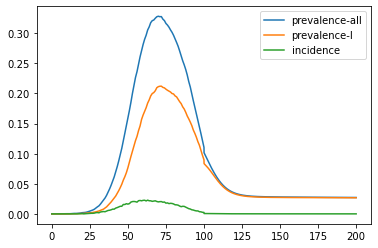

In [272]:
a3.plot()

In [274]:
a3[98:101]

,prevalence-all,prevalence-I,incidence
98.00000,0.133353,0.105542,0.00342058
99.00000,0.121505,0.0973131,0.00267698
100.00000,0.1105,0.0898275,0.00242911
100.00000,0.101827,0.0836581,0.000656687
100.03125,0.101663,0.0835756,0.000655612
100.06250,0.101498,0.0834931,0.00065454
100.09375,0.101334,0.0834106,0.000653469
100.12500,0.10117,0.0833281,0.000652399
100.15625,0.101005,0.0832455,0.000651332
100.18750,0.100841,0.083163,0.000650266


#V_model_d3 = VensimModel("SimpelmodelDelay",wd="./",model_file="Simpelmodel delay.vpmx")
V_model = VensimModel("complexmodel",wd="./", model_file="Vensim_model_2.vpmx")
#nl_model = pyNetLogo.NetLogoLink(gui=True)
#nl_model.load_model('Simpel Virus ABM.nlogo')
nl_df = pd.DataFrame()
V_df = pd.DataFrame()

Defining outcomes and uncertainties